<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/Domoscanova-Irina-branch/Domoscanova%20Irina/AI_%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_Ingate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [29]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загрузка и анализ данных



---


Загрузка данных


---



In [30]:
# Загрузка файла в colab
orders = pd.read_excel('/content/sample_data/data/Аналитика Графики 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
orders.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0




---


Анализ данных


---



In [31]:
# Анализ данных
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype 
---  ------                                                 --------------   ----- 
 0   Категория 3-го уровня                                  254748 non-null  object
 1   Товары                                                 254748 non-null  object
 2   Модель                                                 211411 non-null  object
 3   Ozon ID                                                254748 non-null  int64 
 4   Артикул                                                254748 non-null  object
 5   День                                                   254748 non-null  object
 6   Уникальные посетители, всего                           254748 non-null  int64 
 7   Уникальные посетители с просмотром карточки товара     254748 non-null  int64 
 8   Показы, всего                               



---


Столбцы Товары и Модель имеют несущественные данные для анализа, поэтому принято решение их удалить


---



In [32]:
# Бэкап данных до удаления столбцов
data_backup = orders.copy()
data_backup.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0


In [33]:
from sqlalchemy import true
# Удаление столбцов Товары и Модель
orders.drop('Товары', axis=1, inplace=True)
orders.drop('Модель', axis=1, inplace=True)
orders.head()

,Категория 3-го уровня,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0




---
Перевожу дату в тип DataTime

---




In [34]:
# Перевод даты в индекс
orders.index = pd.to_datetime(orders.День)
orders.head()

,Категория 3-го уровня,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
День,,,,,,,,,,,,,,,,,
2023-03-03,Разное автопринадлежности,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
2023-03-06,Разное автопринадлежности,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
2023-03-07,Разное автопринадлежности,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0


In [35]:
# Удаление лишнего столбца с датой
orders.drop('День', axis=1, inplace=True)
orders.head()

,Категория 3-го уровня,Ozon ID,Артикул,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
День,,,,,,,,,,,,,,,,
2023-03-03,Разное автопринадлежности,882353426,34414,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353426,34414,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353427,34414,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
2023-03-06,Разное автопринадлежности,882353427,34414,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
2023-03-07,Разное автопринадлежности,882353427,34414,44,2,50,2,37,"97,14",0,0,0,0,0,0,0


In [36]:
# Перевод данных столбца Позиция в поиске и каталоге в числовой формат
orders['Позиция в поиске и каталоге'] = orders['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
orders.head()

,Категория 3-го уровня,Ozon ID,Артикул,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
День,,,,,,,,,,,,,,,,
2023-03-03,Разное автопринадлежности,882353426,34414,1,1,6,1,4,1.00,0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353426,34414,1,0,2,0,2,1.00,0,0,0,0,0,0,0
2023-03-05,Разное автопринадлежности,882353427,34414,65,3,69,3,40,110.33,0,0,0,0,0,0,0
2023-03-06,Разное автопринадлежности,882353427,34414,85,3,109,3,46,103.43,0,0,0,0,0,0,0
2023-03-07,Разное автопринадлежности,882353427,34414,44,2,50,2,37,97.14,0,0,0,0,0,0,0




---
Строю матрицу корреляций

---




In [76]:
# Формирую датафрейм для корреляции только с числовыми данными
orders_edit = orders.drop(['Категория 3-го уровня', 'Ozon ID', 'Артикул'], axis=1)
orders_edit.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
День,,,,,,,,,,,,,
2023-03-03,1,1,6,1,4,1.00,0,0,0,0,0,0,0
2023-03-05,1,0,2,0,2,1.00,0,0,0,0,0,0,0
2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0


In [79]:
# Матрица корреляций
orders_corr = orders_edit.corr()
orders_corr

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
"Уникальные посетители, всего",1.000000,0.732794,0.939940,0.638612,0.746789,-0.071336,0.483766,0.320615,0.067563,0.279551,0.028704,0.271871,0.107056
Уникальные посетители с просмотром карточки товара,0.732794,1.000000,0.819049,0.963991,0.457314,-0.077617,0.717365,0.432788,0.088207,0.343063,0.037016,0.456311,0.141114
"Показы, всего",0.939940,0.819049,1.000000,0.792419,0.697687,-0.071741,0.603744,0.363200,0.078202,0.307431,0.029234,0.363404,0.129080
Показы на карточке товара,0.638612,0.963991,0.792419,1.000000,0.401432,-0.071328,0.767477,0.453615,0.093782,0.334787,0.035193,0.509164,0.147298
Показы в поиске и каталоге,0.746789,0.457314,0.697687,0.401432,1.000000,-0.057708,0.328841,0.216744,0.046236,0.197397,0.022522,0.189892,0.086843
Позиция в поиске и каталоге,-0.071336,-0.077617,-0.071741,-0.071328,-0.057708,1.000000,-0.063334,-0.044375,-0.015305,-0.046544,-0.008611,-0.038111,-0.019319
"В корзину, всего",0.483766,0.717365,0.603744,0.767477,0.328841,-0.063334,1.000000,0.566933,0.114327,0.314516,0.026492,0.598029,0.146474
Заказано товаров,0.320615,0.432788,0.363200,0.453615,0.216744,-0.044375,0.566933,1.000000,0.162955,0.235985,0.020652,0.787710,0.108128
Отменено товаров,0.067563,0.088207,0.078202,0.093782,0.046236,-0.015305,0.114327,0.162955,1.000000,0.059986,0.002209,0.134427,0.026275
Доставлено (за выбранный период),0.279551,0.343063,0.307431,0.334787,0.197397,-0.046544,0.314516,0.235985,0.059986,1.000000,0.074527,0.220082,0.380784




---
Визуализация матрицы корреляций

---




In [82]:
# Перевожу orders_corr в npy массив
np_orders_corr = orders_corr.values
print(np_orders_corr.shape)
print(np_orders_corr[0])

(13, 13)
[ 1.          0.73279401  0.93994048  0.6386124   0.74678944 -0.07133603
  0.48376591  0.32061535  0.06756333  0.27955065  0.02870381  0.2718712
  0.10705622]


In [100]:
import matplotlib
matplotlib.colors.Colormap

matplotlib.colors.Colormap

<function matplotlib.pyplot.show(close=None, block=None)>

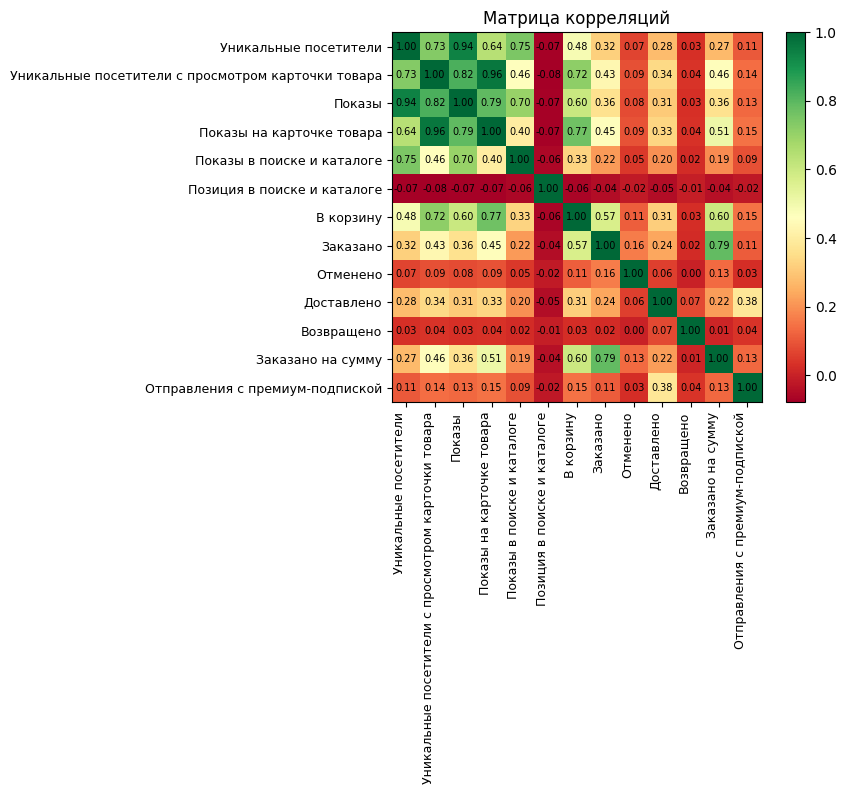

In [135]:
# Строю тепловую карту

# Лейблы оси X
x = ["Уникальные посетители", "Уникальные посетители с просмотром карточки товара", "Показы", "Показы на карточке товара", "Показы в поиске и каталоге", "Позиция в поиске и каталоге", "В корзину", "Заказано", "Отменено", "Доставлено", "Возвращено", "Заказано на сумму", "Отправления с премиум-подпиской"]

# Лейблы оси Y
y = ["Уникальные посетители", "Уникальные посетители с просмотром карточки товара", "Показы", "Показы на карточке товара", "Показы в поиске и каталоге", "Позиция в поиске и каталоге", "В корзину", "Заказано", "Отменено", "Доставлено", "Возвращено", "Заказано на сумму", "Отправления с премиум-подпиской"]

# Построение тепловой карты
fig, ax = plt.subplots()                                                        # Отрисовка рамок и осей
im = plt.imshow(np_orders_corr, cmap='RdYlGn')                                  # Отрисовка данных
ax.set_xticks(np.arange(len(x)), labels=x)                                      # Отрисовка делений и подписей к делениям
ax.set_yticks(np.arange(len(y)), labels=y)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)             # Параметры для подписей делений
plt.setp(ax.get_yticklabels(), fontsize=9)

for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, '{0:0.2f}'.format(np_orders_corr[i, j]),
                       ha="center", va="center", color="black", fontsize=7)

#
fig.colorbar(im)

# Заголовок графика
plt.title('Матрица корреляций')
plt.show